In [1]:
import os
from glob import glob 
import random
import shutil
import numpy as np
from pydub import AudioSegment
import tensorflow as tf


/home/durga/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/durga/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/durga/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/durga/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: Futu

In [22]:
def two_files_audio_sum(file_1_path, file_2_path,file_sum_name, volume_reduction=0):
    s1 = AudioSegment.from_file(file_1_path)
    s2 = AudioSegment.from_file(file_2_path) - volume_reduction # volume_reduction in dB

    s2_shift = (len(s1)-len(s2)) / 2 if len(s1) > len(s2) else 0
    
    audio_sum = s1.overlay(s2, position=s2_shift)
    audio_sum.export(file_sum_name, format='wav')

    return np.array(audio_sum.get_array_of_samples())

In [24]:
mixed_samples=two_files_audio_sum('./bbaf1n.wav','./bbaf2s.wav','./mixed_audio.wav')

In [3]:
from scipy.io import wavfile
from scipy import signal
import math

In [4]:
def downsampling(samples, sample_rate, downsample_rate):
    secs = len(samples) / float(sample_rate)
    num_samples = int(downsample_rate * secs)

    return signal.resample(samples, num_samples)

In [5]:
def compute_spectrograms(audio_file, max_audio_length=48000, sample_rate=16e3, n_fft=512, window_size=25, step_size=10):
    
    
    
    window_frame_size = int(round(window_size / 1e3 * sample_rate))
    step_frame_size = int(round(step_size  / 1e3 * sample_rate))
    
    audio_samples = np.zeros((1, max_audio_length + n_fft//2))
    
    
    rate, samples = wavfile.read(audio_file)
    samples = downsampling(samples, rate, sample_rate)
    audio_samples[0, n_fft//2: len(samples) + n_fft//2] = samples
    num_frames = math.ceil(float(len(samples) + n_fft//2) / step_frame_size)
    
    # Create Graph
    with tf.Graph().as_default():
        samples_tensor = tf.constant(audio_samples, dtype=tf.float32)
        # Compute STFT
        specs_tensor = tf.contrib.signal.stft(samples_tensor, frame_length=window_frame_size, frame_step=step_frame_size,
                                              fft_length=n_fft, pad_end=True)
        # Apply power-law compression
        specs_tensor = tf.abs(specs_tensor) ** 0.3
    
        # Start session
        with tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                              log_device_placement=False)) as sess:
            specs = sess.run(specs_tensor)

    return specs, num_frames

In [6]:
s,n=compute_spectrograms('./bbaf1n.wav')

In [12]:
useful_frames=s[0][:n,:]

In [9]:
import seaborn as sns
sns.set()

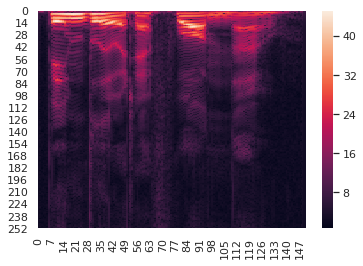

In [20]:
ax = sns.heatmap(np.rollaxis(useful_frames,1,0))